<img src="https://s3.amazonaws.com/datascienceheroes.com/EDV/360_banner_python.png" width="400px">


# Escuela de Datos Vivos 

## LAB P.G.4.2: Balanceo de clases
Creado por Pablo Casas | https://escueladedatosvivos.ai    

Resuelto por Pablo Sotomayor

---

## Ejercicios

- Cargar los datos del laboratorio P.G.4.1 (los de diabetes)
- Hacer undersampling de las clases, van a tener que undersamplear las 3 clases (en este ejemplo usamos 2)
- Analizar cuanto pueden bajar la muestra sin que se vea afectada el área bajo la curva ROC

Hacer este análisis no solo puede ayudar en una entrevista, porque demuestran _la práctica_, sino que también puede ser útil si están ayudando a un data scientist lead a hacer un modelo.

In [1]:
# Librerías que vamos a utilizar

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars
from yellowbrick.classifier import ROCAUC

set_config(display='diagram')

/home/pablo/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Carga de datos

In [2]:
data = pd.read_csv("../data/diabetes_multi_over.csv", sep = ";")

print(f"Cantidad de registros: {data.shape[0]}")
print(f"Cantidad de variables: {data.shape[1]}")

Cantidad de registros: 3072
Cantidad de variables: 9


Inspeccionamos los datos elegiendo una muestra al azar

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,diabetic_type
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,diabetic
1,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,diabetic
2,NaN,137.0,40.0,35.0,168.0,43.1,2.288,33,diabetic
3,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53,diabetic
4,8.0,125.0,96.0,NaN,NaN,NaN,0.232,54,diabetic


Revisamos el estado de los datos

In [4]:
print(f"Cantidad de variables numéricas: {len(num_vars(data))}")
print(f"Cantidad de variables categóricas: {len(cat_vars(data))}")
status(data).sort_values(by=["p_nan", "p_zeros", "unique"], ascending=False)

Cantidad de variables numéricas: 8
Cantidad de variables categóricas: 1


,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
4,Insulin,1496,0.486979,0,0.0,185,float64
3,SkinThickness,908,0.295573,0,0.0,50,float64
0,Pregnancies,444,0.144531,0,0.0,16,float64
2,BloodPressure,140,0.045573,0,0.0,46,float64
5,BMI,44,0.014323,0,0.0,247,float64
1,Glucose,20,0.006510,0,0.0,135,float64
6,DiabetesPedigreeFunction,0,0.000000,0,0.0,517,float64
7,Age,0,0.000000,0,0.0,52,int64
8,diabetic_type,0,0.000000,0,0.0,3,object


No tenemos ceros ni en las variables categóricas ni las numéricas. Tenemos una gran catidad de datos nulos en las variables numéricas, que imputaremos por la mediana. Removemos además la variable "Glucose" por ser redundante con "diabetic_type".

In [5]:
x_data=data.drop(['Glucose','diabetic_type'], axis=1)
y_data=data['diabetic_type']

Separamos los datos en TR y TS

In [6]:
x_tr, x_ts, y_tr, y_ts = train_test_split(x_data, 
                                          y_data, 
                                          test_size=0.2, 
                                          random_state=100)

# Imputamos las variables numéricas por la mediana

In [7]:
num_transformer = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='median'))])
num_transformer

Pipeline(steps=[('num_imputer', SimpleImputer(strategy='median'))])

Juntamos lo anterior en un ColumnTransformer

In [8]:
all_transformer = ColumnTransformer(
    transformers=[
        ('num_t', num_transformer, num_vars(x_tr))])
all_transformer

ColumnTransformer(transformers=[('num_t',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])

Creamos el modelo

In [9]:
pipe_rf = Pipeline(steps=[('all_transformer', all_transformer),
                          ('model_rf', RandomForestClassifier(
                              min_samples_leaf=35, 
                              max_depth=5,
                              min_samples_split=60,
                              random_state=99))])
pipe_rf

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=35,
                                        min_samples_split=60,
                                        random_state=99))])

Entrenamiento del modelo

In [10]:
pipe_rf.fit(x_tr, y_tr)

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=35,
                                        min_samples_split=60,
                                        random_state=99))])

Validación del modelo

/home/pablo/env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


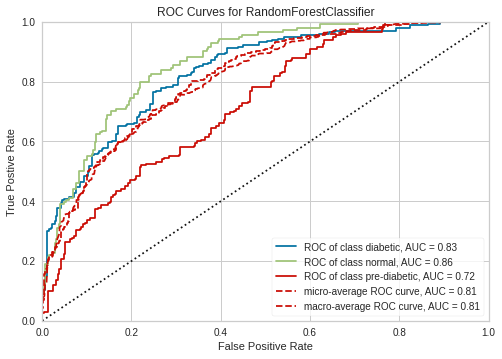

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [11]:
visualizer = ROCAUC(pipe_rf, classes=["diabetic", "normal", "pre-diabetic"])

visualizer.fit(x_tr, y_tr)        # Fit the training data to the visualizer
visualizer.score(x_ts, y_ts)        # Evaluate the model on the test data
visualizer.show()

Imprimimos el reporte de clasificación

In [12]:
y_pred_tr = pipe_rf.predict(x_tr)
y_pred_ts = pipe_rf.predict(x_ts)

In [13]:
print(classification_report(y_tr, y_pred_tr))
print(classification_report(y_ts, y_pred_ts))

              precision    recall  f1-score   support

    diabetic       0.65      0.85      0.73      1001
      normal       0.72      0.45      0.55       614
pre-diabetic       0.58      0.52      0.55       842

    accuracy                           0.64      2457
   macro avg       0.65      0.61      0.61      2457
weighted avg       0.64      0.64      0.62      2457

              precision    recall  f1-score   support

    diabetic       0.66      0.84      0.74       263
      normal       0.69      0.44      0.54       154
pre-diabetic       0.50      0.45      0.48       198

    accuracy                           0.62       615
   macro avg       0.62      0.58      0.58       615
weighted avg       0.62      0.62      0.60       615



Verificamos si las clases están desbalanceadas

In [14]:
freq_tbl(y_tr)

,diabetic_type,frequency,percentage,cumulative_perc
0,diabetic,1001,0.407407,0.407407
1,pre-diabetic,842,0.342694,0.750102
2,normal,614,0.249898,1.000000


Lo están levemente, definimos la estrategia para corregir el desbalance

In [15]:
undersample = RandomUnderSampler(sampling_strategy={'diabetic': 720, 'pre-diabetic': 630, 'normal':614}, 
                                 random_state=100)

In [16]:
undersample = RandomUnderSampler(sampling_strategy={'diabetic': 750, 'pre-diabetic': 631, 'normal':461}, 
                                 random_state=100)

Ajusto y re-muestreamos

In [17]:
x_under, y_under = undersample.fit_resample(x_tr, y_tr)

Verificamos la distribución

In [18]:
freq_tbl(y_under)

,diabetic_type,frequency,percentage,cumulative_perc
0,diabetic,750,0.407166,0.407166
1,pre-diabetic,631,0.342562,0.749729
2,normal,461,0.250271,1.000000


In [19]:
pipe_rf2 = Pipeline(steps=[('all_transformer', all_transformer),
                          ('model_rf',        RandomForestClassifier(min_samples_leaf=35, 
                                                                     max_depth=5,
                                                                     min_samples_split=60,
                                                                     random_state=99))])

pipe_rf2.fit(x_under, y_under)

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=35,
                                        min_samples_split=60,
                                        random_state=99))])

/home/pablo/env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


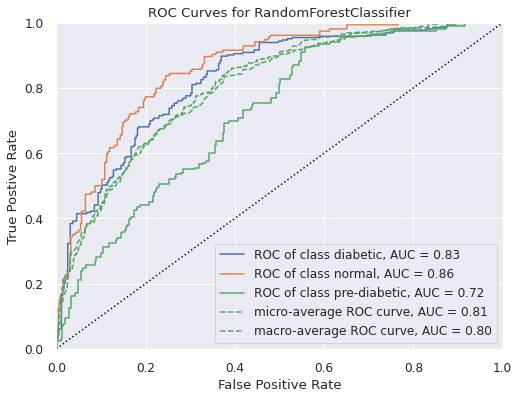

In [20]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.1)

visualizer = ROCAUC(pipe_rf2, classes=["diabetic", "normal", "pre-diabetic"])

visualizer.fit(x_under, y_under)        # Fit the training data to the visualizer
visualizer.score(x_ts, y_ts)        # Evaluate the model on the test data
visualizer.show()
plt.show()

Vemos que disminuyendo en un 25% los datos de entrenamiento obtenemos el mismo valor para el área bajo la curva ROC